Oracle Data Science service sample notebook.

Copyright (c) 2021 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

---

# <font color="red">Text Classification Using PyTorch Lightning</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---

# Overview:

This notebook shows you how to fine tune the pretrained ``Bert`` model from ``transformers`` using PyTorch Lightning for the 20 Newsgroups dataset. The 20 Newsgroups dataset has approximately 20,000 newsgroup posts partitioned evenly across 20 different topics. It's a popular dataset widely used for different machine learning tasks such as topic modeling, text classification, and text clustering.  In this example, we construct a binary classification dataset by selecting the data on two topics, `bydate_rec.sport.baseball` and `bydate_sci.space`, to illustrate how to use PyTorch Lightning to solve a text classification task. 

---

## Contents:

- <a href='#binarytextclassifition'>Binary Text Classification</a>
- <a href='#pytorchlightning'>PyTorch Lightning</a>
- <a href='#Data_Module'>Data Module</a>
- <a href='#Data_Module_define'>Defining the DataModule</a>
- <a href='#LightningModule'>Build Lightning Module</a>
- <a href='#Trainer'>Use Trainer</a>
    - <a href='#Fitting'>Conduct Fitting</a>
    - <a href='#Testing'>Conduct Testing</a>
- <a href='#save'>Save the Model</a>
    - <a href='#prepare'>Prepare the Model Artifact</a>
    - <a href='#modify'>Modify the Model Artifact Files</a>
        - <a href='#modify_init'>Create the `__init__.py` File</a>
        - <a href='#modify_bert'>Create the bert_classifier.py File</a>
        - <a href='#modify_score'>Update `score.py`</a>
    - <a href='#reload'>Reload the Model Artifact</a>
    - <a href='#save_artifact'>Save the Model Artifact</a>
    - <a href='#delete'>Delete the Model Artifact</a>
- <a href='#ref'>References</a>
    
---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials 
under your agreement with Oracle.
    
You can access the `20 Newsgroups` dataset license [here](https://github.com/scikit-learn/scikit-learn/blob/master/COPYING).

---
The notebook is compatible with the following [Data Science conda environment](https://docs.oracle.com/en-us/iaas/data-science/using/conda_environ_list.htm):

* [Natural Language Processing](https://docs.oracle.com/en-us/iaas/data-science/using/conda-nlp-fam.htm) for GPU on Python 3.7 (version 2.0)


In [ ]:
import os
import pytorch_lightning as pl
import shutil
import torch

from datetime import datetime
from datasets import load_dataset, load_metric, concatenate_datasets, DatasetDict
from os import path
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from typing import Optional

<a id='binarytextclassifition'></a>
# Binary Text Classification

Binary text classification is a technique of classifying text sentences into one of two categories. In this notebook, the two categories are `bydate_rec.sport.baseball` and `bydate_sci.space`. Generally, you need to convert text into numerical features first. The basic and traditional ways to convert words to vector representations are N-grams, TF-IDF, and so on. You can also use more advanced vectorization methods such as Word2Vec, GloVe, Fasttext to extract features from the text data. This notebook uses bidirectional encoder representations from transformers (BERT). The pretrained ``BERT`` model can be fine tuned on a relatively smaller text dataset yet still obtains state of the art results for a wide range of tasks, such as text classification, question answering, and language inference. One advantage of BERT is that you don't need to conduct feature engineering expicitly as BERT extracts high quality language features for you. Also, models like Word2Vec and GloVe are a fixed representation of each word regardless of the context. BERT produces dynamic word representations that are informed by the words around them, see [BERT](https://arxiv.org/pdf/1810.04805.pdf).

The library ``transformers`` provides a variety of pretrained models for different tasks that can be easily downloaded, including BERT pretrained models. <font color="red">The purpose of this notebook is not to showcase how to achieve the best performance, but to showcase how to fine tune a pretrained model.</font> This example uses the tiny ``mrm8488/bert-tiny-finetuned-sms-spam-detection`` model that is fast to train. You can obtain more [Hugging Face pretrained models](https://huggingface.co/models?filter=en,pytorch).

<a id='pytorchlightning'></a>
# PyTorch Lightning

You can use PyTorch directly. This notebook introduces PyTorch Lightning, which is used to wrap and organize code to improve the readability. It provides templates to organize the code so that you can easily differentiate the model part, the training part, and so on easily. In addition to the improvement on the code style, it also builds in all the micro-optimizations you can find to increase the performance.

These are the steps that you needed to use PyTorch:

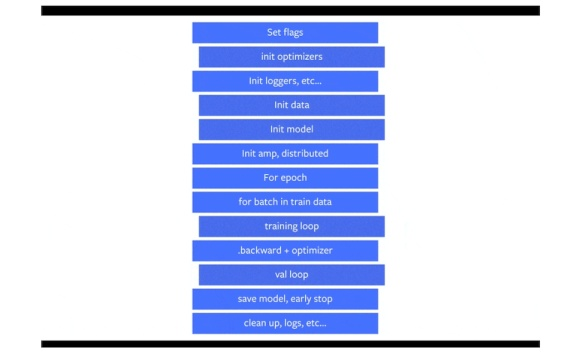

This is how [PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning/blob/master/docs/source/_static/images/general/pl_overview.gif) disentangles PyTorch code to decouple the science from the engineering.

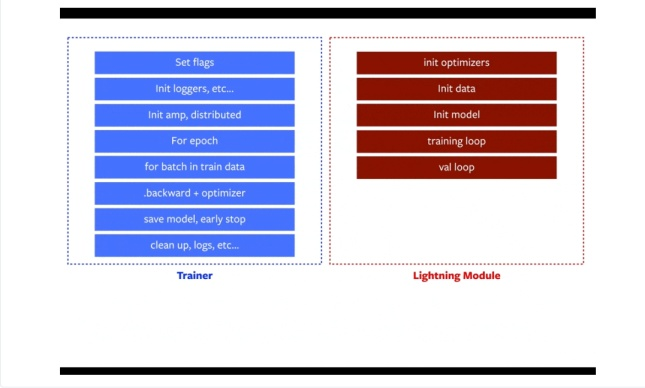


There is quick [guidance on how to organize `PyTorch` into `Lightning`](https://github.com/PyTorchLightning/pytorch-lightning/blob/master/docs/source/_static/images/general/pl_quick_start_full_compressed.gif).

Here is a more detailed overview on the [Lightning module](https://github.com/PyTorchLightning/pytorch-lightning/blob/master/docs/source/_static/images/general/pl_overview_flat.jpg):


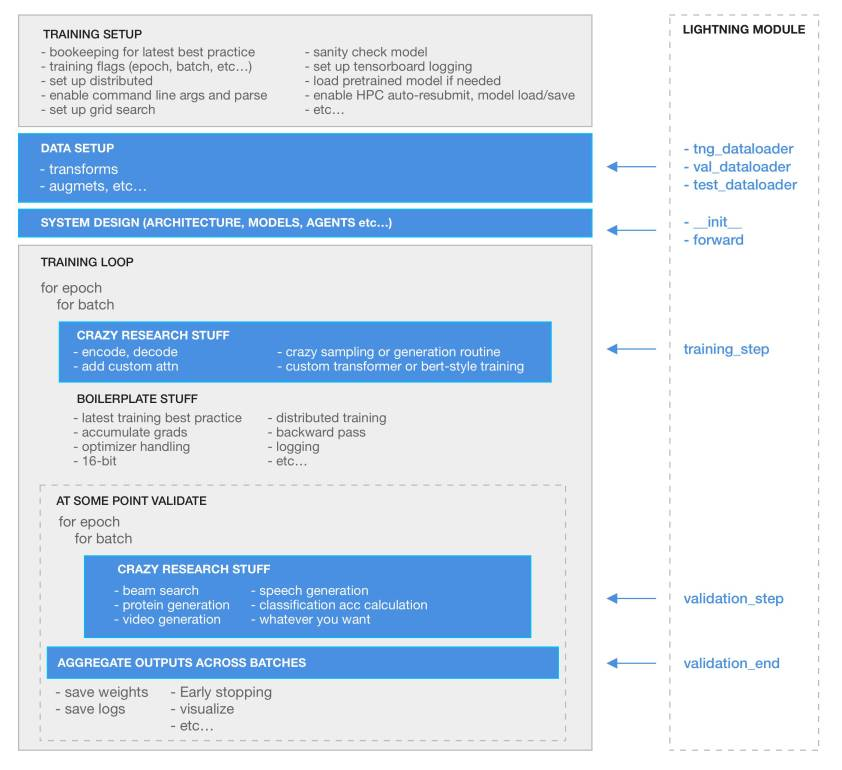

<a id='Data_Module'></a>
# DataModule

DataModules can be used to decouple the data-related hooks from the [`LightningModule`](https://pytorch-lightning.readthedocs.io/en/0.9.0/datamodules.html). A datamodule has five methods:
- ``prepare_data``: Data downloading, tokenization, and so on.
- ``setup``: Data processing, train test split, and so on.
- ``train_dataloader``
- ``val_dataloader(s)``
- ``test_dataloader(s)``

<a id='Data_Module_define'></a>
## Defining the DataModule

These are the main functions under the `DataModule` class:

``__init__``
- `path`: A path argument that specifies the data path. The ``datasets.load_dataset`` argument is used to load the newgroups dataset. It allows you to download any of the public datasets from the HuggingFace hub, load datasets from local CSV, JSON, and text files, and then load datasets from in-memory data.
- `cats`: The list of categories to predict. The notebook uses two categories, `bydate_rec.sport.baseball` and `bydate_sci.space`, from the newsgroups datasets.
- `text`: Text column name in the dataset.
- `label`: Target column name.
- `batch_size`: Size of a batch.
- `seed`: Random seed.
- Defines the BERT tokenizer.

``prepare_data``

- Download the dataset from the [Hugging Face hub](https://huggingface.co/datasets/newsgroup).

``setup``
- Loads and preprocesses the downloaded data, then prepares PyTorch tensor datasets for each split (train, val, and test).
- The `stage` argument in the `setup` function separates the logic for `fit` and `test`.
- If you don't mind loading all your datasets at once, you can set up a condition to allow for both the `fit` and `test` related setups to run whenever `None` is passed to `stage`.
- ``setup()`` is called on every GPU (automatically) and it's safe to assign `state`.

``x_dataloader``
- ``train_dataloader``, ``val_dataloader``, and ``test_dataloader`` load the data into PyTorch DataLoader instances that are defined in the ``setup``. ``Dataloader`` yields a batched sample each time. The order that the batched sample is yielded is controlled by the ``sampler``, which can be defined. By default, ``LightningDataModule`` also offers the correct sampler for distributed and arbitrary hardware so you don't have to pass in the sampler.

In [ ]:
class DataModule(LightningDataModule):
    """
    Data Module to load and clean the newsgroup data
    """

    name = "Newsgroup"

    def __init__(
        self,
        path: str = 'newsgroup',
        cats: list = ['bydate_rec.sport.baseball', 'bydate_sci.space'],
        text: str = 'text',
        label: str = 'labels',
        batch_size: int = 32,
        seed: int = 42,
        *args,
        **kwargs,
    ):
        """
        Args:
            path: data path
            cats: categories that we are going to predict
            text: text column name
            label: target column name
            batch_size: batch size
            seed: random seed
        """
        super().__init__(*args, **kwargs)

        self.path = path
        self.cats = cats
        self.text = text
        self.label = label
        self.batch_size = batch_size
        self.seed = seed
        self.tokenizer = BertTokenizer.from_pretrained('mrm8488/bert-tiny-finetuned-sms-spam-detection', do_lower_case=True)
    
    def prepare_data(self):
        """ predownload the dataset """
        load_dataset(self.path, self.cats[0], split='train')
        load_dataset(self.path, self.cats[1], split='train')

    def setup(self, stage: Optional[str] = None):
        """ Setup function is key when handling dataloaders inside the class since
        this function is triggered when training or testing the model by passing the
        right datasets (training, validation and testing)
        
        Here we load the data on the baseball sport topic and the data the space topic separately, 
        assign labels to them and then comebine them together. Dataset on topic baseball sport
        are labeled as 0 and Dataset on topic space are labeled as 1. Then we shuffle the 
        combined dataset and then split them into train, validation and test datasets.
        """
        baseball_dataset = load_dataset(self.path, self.cats[0], split='train')
        space_dataset = load_dataset(self.path, self.cats[1], split='train')
        baseball_dataset = baseball_dataset.map(lambda x: {'labels': 0})
        space_dataset = space_dataset.map(lambda x: {'labels': 1})
        dataset = concatenate_datasets([baseball_dataset, space_dataset])
        processed_dataset = self.data_preprocessing(dataset)
        processed_dataset.shuffle(seed=self.seed)
        self.train_valid_test_datasets = self.train_valid_test_split(processed_dataset)

    def train_dataloader(self):
        """ Called when training the model """
        loader = DataLoader(
            self.train_valid_test_datasets["train"],
            batch_size = self.batch_size
        )
        return loader

    def val_dataloader(self):
        """ Called when evaluating the model (for each "n" steps or "n" epochs) """
        loader = DataLoader(
            self.train_valid_test_datasets["valid"],
            batch_size = self.batch_size
        )
        return loader

    def test_dataloader(self):
        """ Called when testing the model by calling: Trainer.test() """
        loader = DataLoader(
            self.train_valid_test_datasets["test"],
            batch_size = self.batch_size
        )
        return loader

    def data_preprocessing(self, dataset):
        columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']
        dataset_cleaned = dataset.filter(lambda sent: sent[self.text] is not None)
        encoded_dataset = dataset_cleaned.map(self.convert_to_features, batched=True)
        encoded_dataset.set_format(type='torch', columns=columns)
        return encoded_dataset
           
    def convert_to_features(self, batch):
        encodings = self.tokenizer(text=batch[self.text], 
                          truncation=True,
                          add_special_tokens = True,
                          max_length = 256,       
                          padding = 'max_length',
                          return_attention_mask = True,
                         )
        return encodings

    def train_valid_test_split(self, dataset):
        """ Split the dataset into train(70%), validaton(15%) and test(15%) dataset """
        train_testvalid = dataset.train_test_split(test_size=0.3)
        test_valid = train_testvalid["test"].train_test_split(test_size=0.5)
        train_valid_test_datasets = DatasetDict({
                "train": train_testvalid["train"],
                "valid": test_valid["train"],
                "test": test_valid["test"]})
        return train_valid_test_datasets

You can take a glance of the data generated by `DataModule` using:

```python
dm = DataModule()
dm.prepare_data()
dm.setup('fit')
next(iter(dm.train_dataloader()))
```

<a id='LightningModule'></a>
# LightningModule

PyTorch Lightning recommends organizing the PyTorch code into [(5 parts)](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):
- Computations (`init`).
- Train loop (`training_step`)
- Validation loop (`validation_step`)
- Test loop (`test_step`)
- Optimizers (`configure_optimizers`)

``__init__`` 
- Uses ``save_hyperparameters`` to save the parameters to the checkpoints and can be retrieved using``self.hparams.param_name``.
- Defines the model and the pretrained BERT model is used.
- Defines the metric and accuracy is used.

``forward`` 
- Defines how to get the output. It is only used for inference. 
- ``self(**batch)`` in the ``training_step`` calls ``forward``, and returns the outputs.

``*_step``
- Unlike normal PyTorch code, in the training step you don't need to set the model to train model, or apply and clear gradients using ``zero_grad``, or ask the model to do backpropagation using ``backward()`` and so on because Lightning does that for you.
- Log the metrics.

``configure_optimizers``
- Set up the optimizer and the learning rate scheduler.

In [ ]:
%%writefile bert_classifier.py


import pytorch_lightning as pl
import torch

from transformers import AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification

from pytorch_lightning import LightningDataModule, LightningModule, Trainer


class BertClassifier(LightningModule):
    """
    Fine tune the pretrained bert-base-uncased model on the newsgroup dataset
    """
    def __init__(
        self,
        num_labels: int = 2, # binary classification
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8
    ):
        """
        Args:
            num_labels: Number of labels to ues in the last layer.
            learning_rate: Learning rate.
            adam_epsilon: Adam's epsilon for numerical stability.
        """
        
        super().__init__()
        
        # call this to save (num_labels=2, learning_rate=2e-5, adam_epsilon=1e-8) to the checkpoint
        self.save_hyperparameters()
        
        self.model = BertForSequenceClassification.from_pretrained(
                                                'mrm8488/bert-tiny-finetuned-sms-spam-detection', 
                                                num_labels = self.hparams.num_labels,   
                                                output_attentions = False, 
                                                output_hidden_states = False,
                                            )
        self.accuracy = pl.metrics.Accuracy()

    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx):
        """ Everything that is in the training step gets organized under this function. """
        
        outputs = self(**batch)
        loss = outputs[0]
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def evaluate(self, batch, stage=None):
        outputs = self(**batch)
        loss, logits = outputs[:2]
        if self.hparams.num_labels >= 1:
            preds = torch.argmax(logits, axis=1)
        elif self.num_labels == 1:
            preds = logits.squeeze()
        labels = batch["labels"]
        acc = self.accuracy(preds=preds, target=labels)
        if stage:
            self.log(f'{stage}_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
            self.log(f'{stage}_accuracy', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {f'{stage}_loss': loss}

    def validation_step(self, batch, batch_idx):
        """ Everything that is in the validation step gets organized under this function. """
        return self.evaluate(batch, 'val')

    def test_step(self, batch, batch_idx):
        """ Everything that is in the test step gets organized under this function. """
        return self.evaluate(batch, 'test')

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"
        model = self.model
        optimizer = AdamW(model.parameters(), lr = self.hparams.learning_rate , eps = self.hparams.adam_epsilon)
        self.total_steps = len(self.train_dataloader())
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = self.total_steps)
        scheduler = {
            'scheduler': scheduler,
            'interval': 'step',
            'frequency': 1
        }
        return [optimizer], [scheduler]

<a id='Trainer'></a>
# Trainer

``trainer`` handles training loop details for you including: 

- Automatically enabling and disabling gradients.
- Automatically set the model to be in the evaluation and train mode at the proper times.
- Running the training, validation, and test dataloaders.
- Calling the callbacks at the appropriate times.


To learn more about the flags in the `trainer` object, see the [Pytorch Lightning documentation](https://github.com/PyTorchLightning/pytorch-lightning/blob/master/notebooks/05-trainer-flags-overview.ipynb).

In [ ]:
from bert_classifier import BertClassifier

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)

# saves a file like: my/path/newsgroup-bert-epoch=02-val_accuracy=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='~/lightning_logs/',
    filename='newsgroup-bert-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=1,
    mode='max',
)

trainer = Trainer(logger=True,
                  max_epochs=2,
                  log_every_n_steps=50,
                  gpus= 1 if torch.cuda.is_available() else None,
                  callbacks=[early_stop_callback, checkpoint_callback])

model = BertClassifier()
dm = DataModule()

<a id='Fitting'></a>
## Fitting

You can run `fit` as many times as you want. It only saves the best model based on `val_accuracy` as in the check.

In [ ]:
trainer.fit(model, dm)

<a id='Testing'></a>
## Testing

Since you just trained a model, you only need to call ``trainer.test()`` and Lightning automatically uses the best saved checkpoint.

In [ ]:
trainer.test()

<a id='save'></a>
# Save the Model

After you have trained the model, you may want to save it for future use or implementation somewhere else. This example saves your model to your current project and compartment.

<a id='prepare'></a>
## Prepare the Model Artifact
The next cell shows you how to prepare the model artifact using the [ADS generic model approach](https://docs.oracle.com/en-us/iaas/data-science/using/models_saving_catalog.htm#save-generic).

In [ ]:
import tempfile

from ads.catalog.model import ModelSummaryList, ModelCatalog
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from os import path

# prepare the model artifact template
path_to_generic_model_artifact = tempfile.mkdtemp()
generic_model_artifact = prepare_generic_model(path_to_generic_model_artifact, force_overwrite=True, data_science_env=True)

# Save the checkpoint
trainer.save_checkpoint(path.join(path_to_generic_model_artifact, "newsgroup.ckpt") )

# List the template files
print("Model Artifact Path: {}\n\nModel Artifact Files:".format(path_to_generic_model_artifact))
for file in os.listdir(path_to_generic_model_artifact):
    if path.isdir(path.join(path_to_generic_model_artifact, file)):
        for file2 in os.listdir(path.join(path_to_generic_model_artifact, file)):
            print(path.join(file,file2))
    else:
        print(file)

<a id='modify'></a>
## Modify the Model Artifact Files

The generic model approach provides a template that you have to customize for your use case. In this example, you need to add an `__init__.py` file, a `bert_classifier.py` file to include the `BertClassifier` class, and update the `score.py` accordingly.

<a id='modify_init'></a>
### Create the `__init__.py` File

Use this is to facilitate the relative imports:

In [ ]:
%%capture
init = '''  '''

with open(path.join(path_to_generic_model_artifact, "__init__.py"), 'w') as f:
    print(f.write(init))

<a id='modify_bert'></a>
### Create the bert_classifier.py File
The `bert_classifier.py` file contains the implementation of ``BertClassifier`` class. Then, the `score.py` file imports ``BertClassifier`` and uses it to load the trained model from the checkpoints.

In [ ]:
shutil.copy("bert_classifier.py", path_to_generic_model_artifact)

<a id='modify_score'></a>
### Update `score.py`

Since the generic model approach is agnostic to the model and the serialization method being used, you must provide this information. The `score.py` file provides two methods that need to be updated. These are the `load_model()` and `predict()` methods.

The `load_model()` method takes no parameters and returns the deserialized model object.

The `score.py` file also contains a templated method called `predict()`. This method takes any arbitrary data object and an optional model and returns a dictionary of predictions. The role of this method is to make predictions based on new data. The method can be written to perform any pre-prediction and post-prediction operations that are needed like feature engineering the raw input data and logging predictions results.

In [ ]:
%%capture
score = '''
import json
import os
import sys
import torch
sys.path.insert(0, os.path.dirname(__file__))

from bert_classifier import BertClassifier
from transformers import BertTokenizer, BertForSequenceClassification


model_name = 'newsgroup.ckpt'

def load_model(model_file_name=model_name):
    """
    Loads model from the serialized format

    Returns
    -------
    model: PyTorch Lightning model instance
    """

    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file_name in contents:
        model = BertClassifier.load_from_checkpoint(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name))
        model.eval()
        model.freeze()
        return model
    else:
        raise FileNotFoundError(f'{model_file_name} is not found in model directory {model_dir}.')


def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data as numpy array

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction':output from model.predict method}

    """
    preds_list = []
    for batch in data:
        outputs = model(**batch)
        loss, logits = outputs[:2]
        preds_list.append(torch.argmax(logits, axis=1))
    preds = torch.cat(preds_list, 0)

    return {'prediction': preds}
'''

with open(path.join(path_to_generic_model_artifact, "score.py"), 'w') as f:
    print(f.write(score))

<a id='reload'></a>
## Reload the Model Artifact

The model artifacts on disk are decoupled from the `ModelArtifact` object. Any changes made on disk must be incorporated back into the `ModelArtifact` object. You use the `reload()` method to do this:

In [ ]:
generic_model_artifact.reload(model_file_name="newsgroup.ckpt")

You can call predict to check whether the score.py works.

In [ ]:
inputs = dm.test_dataloader()
generic_model_artifact.predict(inputs)

<a id='save_artifact'></a>
## Save the Model Artifact
Once it works, you can save the model artifact to the model catalog. Let's get our Compartment and Project OCID's:

In [ ]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

Finally, save your model for future use:

In [ ]:
# Saving the model artifact to the model catalog:
mc_model = generic_model_artifact.save(
  project_id=project_id,
  compartment_id=compartment_id,
  display_name="Bert Model For Newsgroup Dataset",
  description="Saving and loading generic model",
  training_script_path="BertClassifier-Lightning.ipynb",
  ignore_pending_changes=True
)
mc_model

<a id='delete'></a>
## Delete Example Models from the Catalog

After we finished work with this example notebook we have to delete any example models saved in the Model Catalog. **Do not delete your own models, working notebook sessions and active projects, that have to be stored in cloud storage.** To delete our example model use `ModelCatalog().delete_model()` method, which requires the OCID of the model to delete as a string, or a Model instance. In this notebook we need to delete `mc_model`:

In [ ]:
mc = ModelCatalog(compartment_id=compartment_id)

to delete with id of model:

In [ ]:
mc.delete_model(mc_model.id)

<a id="ref"></a>
# References

- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)